In [1]:
import os
import glob
from datetime import datetime
from collections import OrderedDict
from itertools import product
from typing import List
import subprocess

import numpy as np
import pandas as pd
import xarray as xr

import satpy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapely.geometry as sgeom

import rasterio
from rasterio.warp import reproject, Resampling, transform
from rasterio.control import GroundControlPoint
from rasterio.transform import xy
from pyresample.geometry import AreaDefinition


#### All channels and products
These are the channels and composite products avilable from this data (Meteosat 10 - SEVIRI)

__Available channels__
```
 ['HRV', 'IR_016', 'IR_039','IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006',
 'VIS008', 'WV_062', 'WV_073']
```

__Available composite products__
```
['airmass', 'ash', 'cloudtop', 'cloudtop_daytime', 'colorized_ir_clouds', 'convection',
 'day_microphysics', 'day_microphysics_winter', 'dust', 'fog', 'green_snow', 'hrv_clouds',
 'hrv_fog', 'ir108_3d', 'ir_cloud_day', 'ir_overview', 'ir_sandwich',
 'natural_color', 'natural_color_raw', 'natural_color_with_night_ir',
 'natural_color_with_night_ir_hires', 'natural_enh', 'natural_with_night_fog', 'night_fog',
 'night_ir_alpha', 'night_ir_with_background', 'night_ir_with_background_hires',
 'night_microphysics', 'overview', 'overview_raw', 'realistic_colors', 'snow', 
 'vis_sharpened_ir']
```


__Most interesting composite products__

These are probably the products we would be interested in to predict daytime PV
```
['cloudtop', 'cloudtop_daytime', 'colorized_ir_clouds',
 'day_microphysics', 'day_microphysics_winter', 'fog', 'green_snow', 'hrv_clouds',
 'hrv_fog', 'ir108_3d', 'ir_cloud_day', 'ir_overview', 'ir_sandwich',
, 'natural_enh', 'natural_with_night_fog', 'snow', 
 'vis_sharpened_ir', 'airmass']
 ```
 
I think instead of using these products we should stick with the raw channels and learn the composite products we would need. Note that the products are simple manipulations of these raw channels anayway.

eg. convective storms product is just:
 - R = Difference WV6.2 - WV7.3
 - G = Difference IR3.9 - IR10.8
 - B = Difference NIR1.6 - VIS0.6
 
Might be okay to ignore the ozone (Ch08 - IR 9.7) and CO2 (Ch11 - IR 13.4) channels. Although IR 9.7 is used to estimate wind speeds and IR 13.4 is used to measure height of semi-transparent clouds.

#### Informative sources

[A collection of documents about various channels and composite products](http://oiswww.eumetsat.org/WEBOPS/msg_interpretation/msg_channels.php).

[Quick overview of some of the composite products](https://eumetview.eumetsat.int/static-images/MSG/RGB/ ).

[Quick overview of IR channels](http://eumetrain.org/data/2/204/204.pdf ) with useful table showing what channels are typically used for what. ie which are informative for clouds.

[Direct download of pdf which contains a blurb for each channel](https://www.eumetsat.int/website/wcm/idc/idcplg?IdcService=GET_FILE&dDocName=PDF_NWS_SEVERICHANS_0401_EN&RevisionSelectionMethod=LatestReleased&Rendition=Web). Really good source of inforamtion for which channels should be helpful for us.

[Direct download of _MSG Level 1.5 Image Data Format Description_](https://www.eumetsat.int/website/wcm/idc/idcplg?IdcService=GET_FILE&dDocName=PDF_TEN_05105_MSG_IMG_DATA&RevisionSelectionMethod=LatestReleased&Rendition=Web#:~:text=The%20Level%201.5%20data%20is,products%20and%20further%20meteorological%20processing.&text=In%20short%2C%20the%20goal%20of,data%20and%20its%20ancillary%20information) with lots of useful information on this SEVIRI data. One keyt takeaway is that in UK the resolution of the data is ~8km N-S and ~4km E-W at the surface for the non-HRV data.

[More technical documents on this data](https://www.eumetsat.int/website/home/Data/TechnicalDocuments/index.html?lang=EN). Most of these reference each other and the above document seems like the place to start on a brief skim.



In [2]:
all_channels = ['HRV', 'IR_016', 'IR_039','IR_087', 'IR_097', 'IR_108', 'IR_120', 
                'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073']

In [3]:
SAT_IMAGERY_PATH = os.path.expanduser('~/repos/predict_pv_yield/data/native_eumetsat')
TEMP_PATH = os.path.expanduser('~/tmp')

In [4]:
ls ~/repos/predict_pv_yield/data/native_eumetsat/2018/07/01/12/04

MSG3-SEVI-MSG15-0100-NA-20180701120416.714000000Z-20180701120435-1360010-1.nat.bz2
MSG3-SEVI-MSG15-0100-NA-20180701120416.714000000Z-20180701120435-1360012-1.nat.bz2


In [5]:
# Native coordinate reference system of SEVIRI
SRC_CRS = {
        'proj': 'geos',  # Geostationary
        'lon_0': 9.5,
        'a': 6378169.0,
        'b': 6356583.8,
        # The EUMETSAT docs say "The distance between spacecraft and centre of earth is 42,164 km. The idealized earth
        # is a perfect ellipsoid with an equator radius of 6378.1690 km and a polar radius of 6356.5838 km." 
        # The projection used by SatPy expresses height as height above the Earth's surface (not distance
        # to the centre of the Earth).
        'h': 35785831.00,  # Height of satellite above the Earth's surface
        'units': 'm'  # meters
}


# Hard-code destination transform 
# Taken as the same grid as Metoffice NWP
#    > see http://cedadocs.ceda.ac.uk/1334/1/uk_model_data_sheet_lores1.pdf
DST_CRS = 'EPSG:27700'
METERS_PER_PIXEL = 2000
WEST=-239_000
SOUTH=-185_000
EAST=857_000
NORTH=1223_000 
DST_WIDTH = int(abs((EAST - WEST)) / METERS_PER_PIXEL)
DST_HEIGHT = int(abs((NORTH - SOUTH)) / METERS_PER_PIXEL)


DST_TRANSFORM = rasterio.transform.from_bounds(
    west=WEST, south=SOUTH, east=EAST, north=NORTH, width=DST_WIDTH, height=DST_HEIGHT)

In [6]:
class UKVDomain(ccrs.OSGB):
    """The geographical domain of the UK Met Office UKV model."""
    
    @property
    def x_limits(self):
        return (WEST, EAST)
    
    @property
    def y_limits(self):
        return (SOUTH, NORTH)
    
    @property
    def boundary(self):
        return sgeom.LineString([
            (WEST, SOUTH), 
            (WEST, NORTH), 
            (EAST, NORTH), 
            (EAST, SOUTH), 
            (WEST, SOUTH)])
    
lat_lons = pd.DataFrame(
    {'london': {'lat': 51.5074, 'lon': 0.1278}}).T

reprojected_x, reprojected_y = transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=lat_lons['lon'],
    ys=lat_lons['lat'])

In [7]:
def get_directory_for_datetime(sat_imagery_path: str, dt: datetime) -> str:
    """
    Args:
        sat_imagery_path:
        dt: the datetime for the requested image.  Will return
            the directory which is within 5 minutes of the requested image.
    Returns:
        Directory string
        
    Raises:
        FileNotFoundError
    """
    hour_path = dt.strftime("%Y/%m/%d/%H")
    hour_path = os.path.join(SAT_IMAGERY_PATH, hour_path)
    
    # Get a list of subdirectories containing minutes
    try:
        _, minute_dirs, _ = next(os.walk(hour_path))
    except StopIteration:
        raise FileNotFoundError
    minutes_with_images = np.array(minute_dirs, dtype=int)
    
    # Quantize dt.minute to 5-minute intervals
    minute_lower_bound = (dt.minute // 5) * 5
    minute_upper_bound = minute_lower_bound + 5
    
    # Find matching directory for the minutes
    selection_condition = (
        (minute_lower_bound <= minutes_with_images) & 
        (minutes_with_images < minute_upper_bound))
    idx = np.flatnonzero(selection_condition)
    
    # Sanity check
    if idx.size == 0:
        raise FileNotFoundError(2, 'No minute directory for datetime {} under "{}"'.format(dt, hour_path))
    elif idx.size > 1:
        raise RuntimeError(
            'Found > 1 directories with images for datetime {}.'
            '  Base dir = "{}".  Subdirs found = {}'
            .format(dt, hour_path, minute_dirs))
        
    selected_minute_dir = minutes_with_images[idx[0]]
    selected_minute_dir = '{:02d}'.format(selected_minute_dir)
    selected_minute_dir = os.path.join(hour_path, selected_minute_dir)
    
    return selected_minute_dir

In [8]:
def get_image_filename_for_datetime(
    sat_imagery_path: str, 
    dt: datetime,
    pattern: str = 'MSG*.nat.bz2',
    ) -> str:
    
    image_path = get_directory_for_datetime(sat_imagery_path, dt)
    files = glob.glob(os.path.join(image_path, pattern))[:1]
    error_str = 'file matching "{}" in "{}" for datetime {}.'.format(pattern, image_path, dt)
    if len(files) == 0:
        raise FileNotFoundError(2, 'No ' + error_str)
    if len(files) > 1:
        raise RuntimeError('Found > 1 ' + error_str + '  Expected only one match.', files)
    image_filename = files[0]
    return image_filename

In [9]:
def decompress(full_bzip_filename: str) -> str:
    base_bzip_filename = os.path.basename(full_bzip_filename)
    base_nat_filename = os.path.splitext(base_bzip_filename)[0]
    full_nat_filename = os.path.join(TEMP_PATH, base_nat_filename)
    if os.path.exists(full_nat_filename):
        os.remove(full_nat_filename)
    with open(full_nat_filename, 'wb') as nat_file_handler:
        process = subprocess.run(
            ['pbzip2', '--decompress', '--keep', '--stdout', full_bzip_filename],
            stdout=nat_file_handler)
    process.check_returncode()
    return full_nat_filename

In [13]:
def combine_attributes(hrv_attrs, visir_attrs):
    """Very rough function to port some of the attributes.
    Some need to be modified so can be saved to netcdf."""
    overrided = {'resolution'}
    drop = set() #{'area', 'ancillary_variables', }
    if hrv_attrs is not None and visir_attrs is not None:
        attrs = {k:hrv_attrs[k] for k in set(hrv_attrs.keys())&set(visir_attrs.keys())-overrided-drop
                 if hrv_attrs[k]==visir_attrs[k]}
        attrs['HRV_original_source'] = {k:hrv_attrs[k] for k in set(hrv_attrs.keys())-set(attrs.keys())-drop}
        attrs['VIS_IR_original_source'] = {k:visir_attrs[k] for k in set(visir_attrs.keys())-set(attrs.keys())-drop}    
    elif hrv_attrs is not None:
        attrs = {k:hrv_attrs[k] for k in set(hrv_attrs.keys())-overrided-drop}
        attrs['HRV_original_source'] = {k:hrv_attrs[k] for k in set(hrv_attrs.keys())-set(attrs.keys())-drop}
    else:
        attrs = {k:visir_attrs[k] for k in visir_attrs.keys() if k not in overrided}
        attrs['HRV_original_source'] = {k:visir_attrs[k] for k in set(visir_attrs.keys())-set(attrs.keys())-drop}
    attrs['projection'] = DST_CRS
    if 'start_time' in attrs.keys():
        attrs['start_time'] = attrs['start_time'] .isoformat()
    if 'end_time' in attrs.keys():
        attrs['end_time'] = attrs['end_time'] .isoformat()
    attrs = {k:str(v) for k, v in attrs.items()}
    return attrs

In [10]:
def reproject_xr(raw_ds: xr.Dataset, area_extent: List[float], dt: datetime) -> xr.Dataset:

    raw_image = raw_ds.to_array().values
    raw_channels, raw_height, raw_width = raw_image.shape
    channel_names = np.array([k for k in raw_ds.keys()], dtype=str)
    
    # Make array of NaNs to accept transformed image
    dst_shape = (raw_channels, DST_HEIGHT, DST_WIDTH)
    dst_array = np.full(dst_shape, np.nan, dtype=np.float32)
    
    # create ground control points from extent
    left, bottom, right, top = area_extent
    ground_control_points = [
        GroundControlPoint(row=0, col=0, x=left, y=top, id='top_left'),
        GroundControlPoint(row=raw_height, col=0, x=left, y=bottom, id='bottom_left'),
        GroundControlPoint(row=raw_height, col=raw_width, x=right, y=bottom, id='bottom_right'),
        GroundControlPoint(row=0, col=raw_width, x=right, y=top, id='top_right'),
    ]
    
    # Reproject
    reproject(
        raw_image,
        dst_array,
        src_crs=SRC_CRS,
        dst_crs=DST_CRS,
        gcps=ground_control_points,
        dst_transform=DST_TRANSFORM,
        num_threads=8,
        resampling=Resampling.cubic,
        src_nodata=np.nan)
    
    # Get X's and Y's (coordinates of each column and row, respectively)
    n = max(DST_HEIGHT, DST_WIDTH)
    xs, ys = xy(
        transform=DST_TRANSFORM,
        rows=np.arange(n),
        cols=np.arange(n))
    ys = ys[:DST_HEIGHT]
    xs = xs[:DST_WIDTH]
    
    # The Xs and Ys are integers represented as floats even though they
    # are integer values, so convert to ints.
    ys = np.int64(ys)
    xs = np.int64(xs)
    

    dims = OrderedDict()
    dims['time'] = [dt]
    dims['y'] = ys#+5000
    dims['x'] = xs#-3000

    ds = xr.Dataset(
        {c:(dims.keys(), x[np.newaxis,...]) for x, c in zip(dst_array, channel_names)},
        coords=dims,
        attrs=raw_ds.attrs)
    
    return ds

    
def get_reprojected_image(sat_imagery_path, dt, columns=['HRV',], apply_hand_tunig=False) -> xr.DataArray:
    # check columns valid
    assert set(columns)-set(all_channels)==set(), 'columns chosen not valid'
    
    # get filename and unzip
    full_bzip_filename = get_image_filename_for_datetime(sat_imagery_path, dt)
    full_nat_filename = decompress(full_bzip_filename)
    
    # HRV has different grid so must be treated seperatrely
    include_hrv = 'HRV' in columns
    columns_visir = [c for c in columns if c!='HRV']
    include_visir = bool(len(columns_visir))
    
    # load all required datasets
    scene = satpy.Scene(
        filenames=[full_nat_filename],
        reader='seviri_l1b_native')
    scene.load(columns)
    
    # handler is instance of https://satpy.readthedocs.io/en/latest/_modules/satpy/readers/seviri_l1b_native.html
    handler = scene.readers['seviri_l1b_native'].file_handlers['native_msg'][0]
    # alternatively can make a new handler as below
    #handler = satpy.readers.seviri_l1b_native.NativeMSGFileHandler(full_nat_filename, {}, None)
    
    # need to manually set this to true so .get_area_extent() returns correct values
    handler.mda['is_full_disk']=True
    
    # function to select dataset_id given it's name
    select_dataset_id_by_name = lambda name : list(filter(lambda x: x.name==name, scene.all_dataset_ids()))
    
    # HRV has upper and lower area extent. lower seems to be correct and matches with Jack's hardcoded numbers
    _, area_extent_hrv, *_ = handler.get_area_extent(select_dataset_id_by_name('HRV')[1])
    if apply_hand_tunig:
        # these values were tuned by eye by plotting reprojected map
        left, bottom, right, top = area_extent_hrv
        xoff = -500
        yoff = 2000
        area_extent_hrv = left+xoff, bottom+yoff, right+xoff, top+yoff
    
    # Confirm that all visir extents are the same
    if include_visir:
        area_extents_visir = [handler.get_area_extent(select_dataset_id_by_name(column)[0]) for column in columns_visir]
        assert all([area_extent==area_extents_visir[0] for area_extent in area_extents_visir]), 'VIS_IR area extents not the same'
        area_extent_visir = area_extents_visir[0]
        if apply_hand_tunig:
            left, bottom, right, top = area_extent_visir
            # these values were tuned by eye by plotting reprojected map
            xoff = 0
            yoff = -1000
            area_extent_visir = left+xoff, bottom+yoff, right+xoff, top+yoff
    
    # HRV is on different grid to other data. Separate it out
    ds_hrv = scene.to_xarray_dataset(datasets=['HRV']) if include_hrv else None
    ds_visir = scene.to_xarray_dataset(datasets=columns_visir) if include_visir else None
    
    # clean up unpacked data
    os.remove(full_nat_filename)
    
    # reproject
    vis_ir_columns = [c for c in columns if c!='HRV']
    if include_hrv:
        ds_reprojected_hrv = reproject_xr(ds_hrv, area_extent_hrv, dt)
    if include_visir:
        ds_reprojected_visir = reproject_xr(ds_visir, area_extent_visir, dt)
    
    if include_hrv and include_visir:
        # combine
        ds = ds_reprojected_hrv.merge(ds_reprojected_visir)
    elif include_hrv:
        ds = ds_reprojected_hrv
    else:
        ds = ds_reprojected_visir
    
    ds.attrs = combine_attributes(ds_hrv.attrs if ds_hrv is not None else None, 
                                  ds_visir.attrs if ds_visir is not None else None, )
    
    return ds

In [14]:
%%time
import warnings

#dt = datetime(year=2018, month=7, day=1, hour=12, minute=59)
#dt = datetime(year=2018, month=10, day=5, hour=12, minute=59)
dt = datetime(year=2018, month=9, day=9, hour=8, minute=59)
ds = get_reprojected_image(SAT_IMAGERY_PATH, dt, all_channels[0:3], apply_hand_tunig=True)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/opt/conda/lib/python3.7/site-packages/dask/core.py:121: R

CPU times: user 2.76 s, sys: 772 ms, total: 3.54 s
Wall time: 3.93 s


In [98]:
ls /home/davidjamesfulton93/staging/upload/2018/09/05/

2018-09-05T00_allchannels.nc  2018-09-05T12_allchannels.nc
2018-09-05T01_allchannels.nc  2018-09-05T13_allchannels.nc
2018-09-05T02_allchannels.nc  2018-09-05T14_allchannels.nc
2018-09-05T03_allchannels.nc  2018-09-05T15_allchannels.nc
2018-09-05T04_allchannels.nc  2018-09-05T16_allchannels.nc
2018-09-05T05_allchannels.nc  2018-09-05T17_allchannels.nc
2018-09-05T06_allchannels.nc  2018-09-05T18_allchannels.nc
2018-09-05T07_allchannels.nc  2018-09-05T19_allchannels.nc
2018-09-05T08_allchannels.nc  2018-09-05T20_allchannels.nc
2018-09-05T09_allchannels.nc  2018-09-05T21_allchannels.nc
2018-09-05T10_allchannels.nc  2018-09-05T22_allchannels.nc
2018-09-05T11_allchannels.nc  2018-09-05T23_allchannels.nc


In [129]:
ds = xr.open_mfdataset('/home/davidjamesfulton93/staging/upload/2018/09/05/*.nc', combine='by_coords')

In [139]:
ds.time.values[200]

numpy.datetime64('2018-09-05T16:54:00.000000000')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  


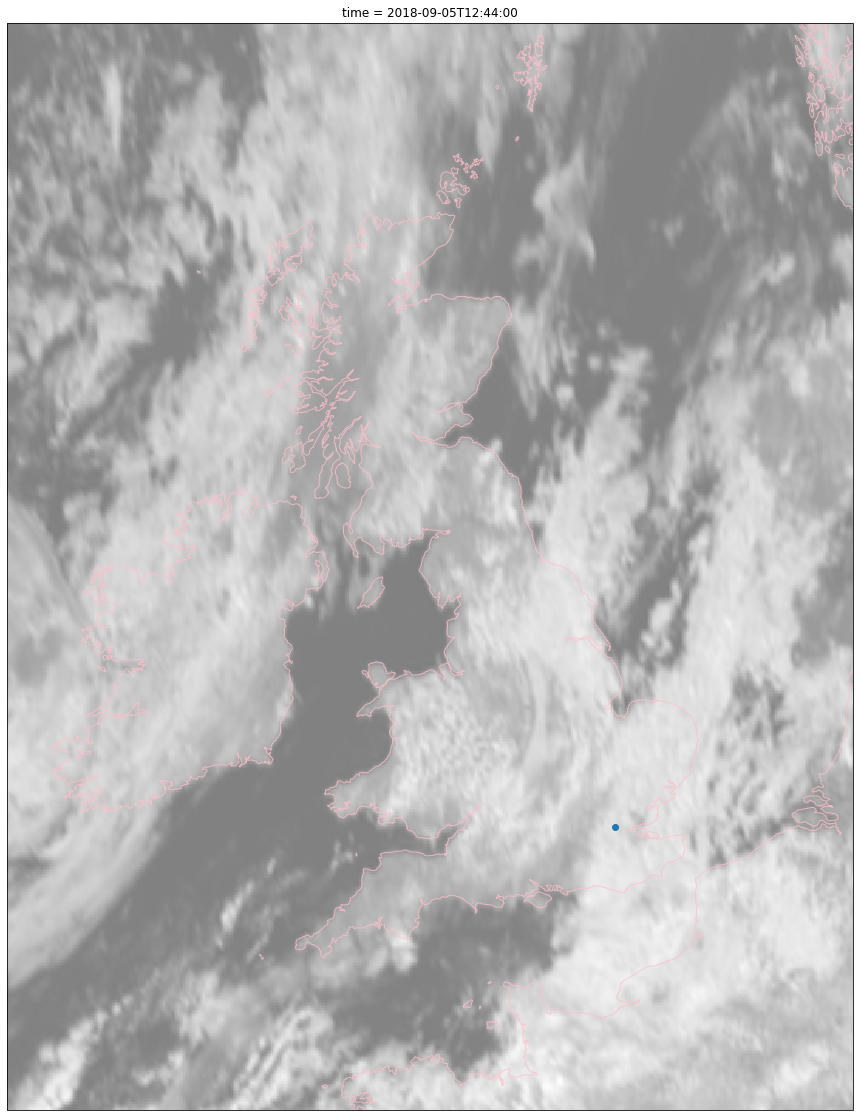

In [155]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=UKVDomain())
ax.coastlines(resolution='10m', alpha=0.8, color='pink')
ax.scatter(reprojected_x, reprojected_y)

ds[list(ds.keys())[1]].isel(time=150).plot.imshow(ax=ax, cmap='gray', add_colorbar=False);

In [22]:
ds

<xarray.Dataset>
Dimensions:  (time: 12, x: 548, y: 704)
Coordinates:
  * x        (x) int64 -239000 -237000 -235000 -233000 ... 851000 853000 855000
  * y        (y) int64 1221999 1219997 1217996 ... -180996 -182997 -184999
  * time     (time) datetime64[ns] 2018-09-05T11:59:00 ... 2018-09-05T12:54:00
Data variables:
    HRV      (time, y, x) float32 8.129905 8.328472 ... 16.898766 17.309902
    IR_016   (time, y, x) float32 1.0968268 1.5094439 ... 20.471447 20.972971
    IR_039   (time, y, x) float32 273.19293 273.82056 ... 287.83194 287.89648
    IR_087   (time, y, x) float32 273.24362 273.16434 ... 274.97034 274.05066
    IR_097   (time, y, x) float32 242.14935 242.06917 ... 251.58144 250.75795
    IR_108   (time, y, x) float32 277.29727 277.2664 ... 274.56403 273.552
    IR_120   (time, y, x) float32 275.26547 275.27274 ... 270.14865 268.9328
    IR_134   (time, y, x) float32 250.56421 250.60446 ... 248.77176 248.1457
    VIS006   (time, y, x) float32 6.4426622 6.5588946 ... 14.342787 15.126538
    VIS008   (time, y, x) float32 3.5874448 3.872496 ... 24.417404 24.518412
    WV_062   (time, y, x) float32 237.09229 237.08832 ... 229.45903 229.28004
    WV_073   (time, y, x) float32 246.43692 246.58492 ... 246.29958 245.96754
Attributes:
    orbital_parameters:      {'projection_longitude': 9.5, 'projection_latitu...
    level:                   None
    modifiers:               ()
    sensor:                  seviri
    ancillary_variables:     []
    start_time:              2018-09-05T11:55:11.165052
    polarization:            None
    end_time:                2018-09-05T12:00:11.184942
    platform_name:           Meteosat-10
    HRV_original_source:     {'wavelength': (0.5, 0.7, 0.9), 'calibration': '...
    VIS_IR_original_source:  {'area': Area ID: geos_seviri_visir\nDescription...
    projection:              EPSG:27700